
The feature selection notebook does a filter followed by a wrapper. It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ...

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

If balance = 0 the entire files are used. If balance != 0 then balance is the ratio of goods to bads retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. 

In [1]:
# load libraries
# %pip install mlxtend
# %pip install lightgbm

import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.feature_selection import RFE

from mlxtend.feature_selection import ExhaustiveFeatureSelector

%matplotlib inline
start_time = dt.datetime.now()

In [2]:
# set some parameters
num_files = 1
num_filter = 80
num_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
# index_name = 'record'
# y_name = 'fraud_label'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [3]:

%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'vars.csv'
    df = pd.read_csv(file_name,index_col = [0])
#     df = df.drop(columns=['Date', 'Amount'])
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
    df = df[df.index <= 84300] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 2995] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)
    
    """
    Not that it matters a lot but I usually put the dataframes in a list and concatenate them after coming out of loop.
    Someone at my previous organization said that it was more efficient but I did not check the efficiency benefit myself.
    """
#     filter_score = pd.concat([filter_score,new])
    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on vars.csv size is (96397, 515)
100
200
300
400
500
vars.csv                 variable     score
1                  Fraud  1.000000
309     card_zip_total_7  0.684729
357   card_merch_total_7  0.681017
301     card_zip_total_3  0.677675
349   card_merch_total_3  0.675054
365  card_merch_total_14  0.674867
253   card_state_total_3  0.674178
317    card_zip_total_14  0.672277
261   card_state_total_7  0.669661
269  card_state_total_14  0.668943
293     card_zip_total_1  0.660589
245   card_state_total_1  0.659137
373  card_merch_total_30  0.658264
341   card_merch_total_1  0.658215
315      card_zip_max_14  0.657954
307       card_zip_max_7  0.657548
325    card_zip_total_30  0.656706
363    card_merch_max_14  0.654180
323      card_zip_max_30  0.651397
355     card_merch_max_7  0.650624
CPU times: user 12.9 s, sys: 2.04 s, total: 14.9 s
Wall time: 15.2 s


In [4]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)

In [5]:
filter_score.head(30)

,variable,score
1,Fraud,1.000000
309,card_zip_total_7,0.684729
357,card_merch_total_7,0.681017
301,card_zip_total_3,0.677675
349,card_merch_total_3,0.675054
365,card_merch_total_14,0.674867
253,card_state_total_3,0.674178
317,card_zip_total_14,0.672277
261,card_state_total_7,0.669661
269,card_state_total_14,0.668943


In [6]:
filter_score.tail(10)

,variable,score
36,card_amount_count_0,0.070419
103,card_amount_count_1_by_7,0.067253
497,Merchnum_unique_count_for_Cardnum_1,0.063108
496,Merchnum_unique_count_for_Cardnum_0,0.060309
120,card_merch_count_1_by_14,0.060124
87,card_state_count_1_by_7,0.055453
98,card_amount_count_0_by_3,0.045219
514,RANDOM,0.033366
102,card_amount_count_1_by_3,0.032728
508,Amount_unique_count_for_Merchnum_0,0.029418


In [7]:
filter_score.shape

(515, 2)

In [8]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(' vars_keep:',vars_keep)

 vars_keep: ['card_zip_total_7', 'card_merch_total_7', 'card_zip_total_3', 'card_merch_total_3', 'card_merch_total_14', 'card_state_total_3', 'card_zip_total_14', 'card_state_total_7', 'card_state_total_14', 'card_zip_total_1', 'card_state_total_1', 'card_merch_total_30', 'card_merch_total_1', 'card_zip_max_14', 'card_zip_max_7', 'card_zip_total_30', 'card_merch_max_14', 'card_zip_max_30', 'card_merch_max_7', 'card_zip_max_3', 'card_merch_max_30', 'card_state_max_3', 'card_state_max_7', 'card_merch_max_3', 'card_state_total_30', 'card_state_max_14', 'card_zip_max_1', 'card_state_max_1', 'card_merch_max_1', 'merch_state_total_3', 'card_merch_total_0', 'card_state_total_0', 'card_zip_total_0', 'merch_state_max_0', 'merch_state_total_1', 'card_zip_max_0', 'card_state_max_0', 'merch_zip_total_3', 'Cardnum_total_3', 'card_zip_avg_30', 'merch_zip_max_0', 'card_merch_max_0', 'Cardnum_total_7', 'merch_zip_total_1', 'card_state_max_30', 'Merchnum_max_0', 'card_zip_avg_14', 'card_merch_avg_30', 

In [9]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,card_zip_total_7,card_merch_total_7,card_zip_total_3,card_merch_total_3,card_merch_total_14,card_state_total_3,card_zip_total_14,card_state_total_7,card_state_total_14,card_zip_total_1,...,merch_state_max_3,Merchnum_max_1,merch_zip_avg_1,merch_zip_total_0,card_merch_avg_0,card_zip_avg_0,merch_zip_max_3,card_state_avg_14,Merchnum_avg_1,card_state_avg_0
Recnum,,,,,,,,,,,,,,,,,,,,,
2995,1023.04,1023.04,174.20,174.20,1023.04,174.20,1023.04,1023.04,1023.04,174.20,...,2454.99,174.20,174.2000,174.20,174.20,174.20,2454.99,341.013333,174.2000,174.20
2996,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,...,250.00,250.00,250.0000,250.00,250.00,250.00,250.00,250.000000,250.0000,250.00
2997,76.85,76.85,76.85,76.85,76.85,76.85,76.85,76.85,76.85,53.88,...,1097.60,999.90,223.3100,53.88,53.88,53.88,1097.60,38.425000,223.3100,53.88
2998,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,...,2237.00,1269.00,370.3375,1269.00,1269.00,1269.00,2237.00,1269.000000,370.3375,1269.00
2999,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,...,601.52,601.52,396.5600,288.38,288.38,288.38,601.52,288.380000,396.5600,288.38


In [10]:
df_keep.shape

(80983, 80)

In [11]:
Y.head()

,Fraud
Recnum,
2995,0
2996,0
2997,0
2998,0
2999,0


In [12]:
Y = Y.values
Y_save = Y.copy()

In [13]:
# Y = np.array(Y)
X = df_keep
print(Y)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [14]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:00:15.317031


In [15]:
print(X.shape,Y.shape)

(80983, 80) (80983, 1)


In [16]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [17]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)
#     goods = 

In [18]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

In [19]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get 
# a sorted list of num_wrapper variables.
nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=30,num_leaves=3) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=False,verbose=2,scoring=fdr,cv=10,n_jobs=-1) # forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=2,scoring=fdr,cv=2,n_jobs=-1) # backward selection
sfs.fit(X,Y)

/Users/Justin/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/Justin/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/Justin/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/Justin/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.7min finished

[2022-05-03 16:35:46] Features: 59/20 -- score: 0.6958834536220262[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:  2.6min finished

[2022-05-03 16:38:21] Features: 58/20 -- score: 0.6958834536220262[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:  2.8min finished

[2022-05-03 16:41:11] Features: 57/20 -- score: 0.6958834536220262[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:  2.6min finished

[2022-05-03 16:43:45] Features: 56/20 

[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   37.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   37.3s finished

[2022-05-03 17:24:30] Features: 27/20 -- score: 0.6970462443197006[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   36.4s finished

[2022-05-03 17:25:06] Features: 26/20 -- score: 0.6970462443197006[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   34.3s finished

[2022-05-03 17:25:41] Features: 25/20 -- score: 0.6970462443197006[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   27.4s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   32.3s finished

[2022-05-03 17:26:13] Features: 24/20 -- score: 0.6981956696070569[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 co

CPU times: user 1min 59s, sys: 2min 29s, total: 4min 29s
Wall time: 2h 10min 27s


SequentialFeatureSelector(cv=10,
                          estimator=LGBMClassifier(n_estimators=30,
                                                   num_leaves=3),
                          forward=False, k_features=20, n_jobs=-1,
                          scoring=<function fdr at 0x7feb0e434ee0>, verbose=2)

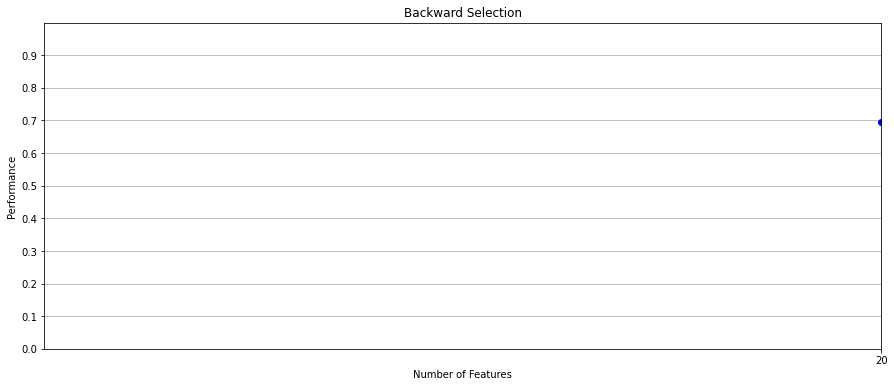

In [20]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(20,80, step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,num_wrapper)
plt.title('Backward Selection')
plt.grid()
plt.savefig('FS_fdr.png')
plt.show()

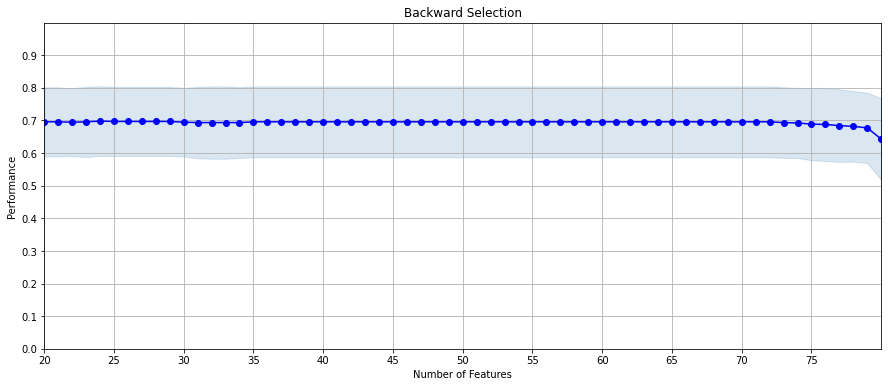

In [25]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(20,80)
plt.title('Backward Selection')
plt.grid()
plt.savefig('FS_fdr.png')
plt.show()

In [24]:
vars_FS.to_excel('vicky20.xlsx')

In [21]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

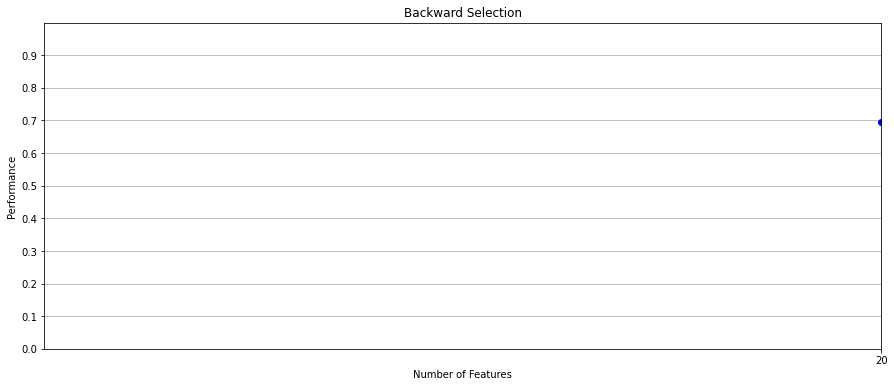

In [22]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(20,80, step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,num_wrapper)
plt.title('Backward Selection')
plt.grid()
plt.savefig('FS_fdr.png')
plt.show()

In [22]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = list(ordered_vars_FS.loc[i+1,'feature_names'])[0]
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])

TypeError: 'float' object is not iterable

In [ ]:
ordered_vars_FS

In [ ]:
ordered_vars_FS.to_csv('VarsFS.csv', index=False)

In [ ]:
ordered_vars_FS['variable name']

In [ ]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)

In [ ]:
vars_keep

In [ ]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

In [ ]:
df = pd.read_csv(file_name)

In [ ]:
df_keep = df.filter(vars_keep_list, axis=1)
print(df_keep.shape)

In [ ]:
df_keep.to_csv('vars_final.csv',index=False)

In [ ]:
print('time to here:', dt.datetime.now() - start_time)